In [1]:
import os
import sys
import numpy as np
import pandas as pd
from tqdm import tqdm
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error

import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional, GRU, Embedding, Dropout
from keras.optimizers import RMSprop
from keras import backend as K

import warnings
warnings.filterwarnings('ignore')

sys.path.insert(0, '../src')

from utils import *
from features import *

Using TensorFlow backend.


In [2]:
fp_240 = '../data/240p/' 
fp_360 = '../data/360p/' 
fp_480 = '../data/480p/'
fp_720 = '../data/720p/'
fp_1080 = '../data/1080p/' 

In [3]:
dfs_240 = []
for file in os.listdir(fp_240):
    if file != '.ipynb_checkpoints' and file != '.DS_Store':
        dfs_240.append(pd.read_csv(fp_240+file))
    
dfs_360 = []
for file in os.listdir(fp_360):
    if file != '.ipynb_checkpoints' and file != '.DS_Store':
        dfs_360.append(pd.read_csv(fp_360+file))
        
dfs_480 = []
for file in os.listdir(fp_480):
    if file != '.ipynb_checkpoints' and file != '.DS_Store':
        dfs_480.append(pd.read_csv(fp_480+file))
        
dfs_720 = []
for file in os.listdir(fp_720):
    if file != '.ipynb_checkpoints' and file != '.DS_Store':
        dfs_720.append(pd.read_csv(fp_720+file))

dfs_1080 = []
for file in os.listdir(fp_1080):
    if file != '.ipynb_checkpoints' and file != '.DS_Store':
        dfs_1080.append(pd.read_csv(fp_1080+file))

In [4]:
ms_240 = []
for df in dfs_240:
    ms_240.append(convert_ms_df(df,True))
    
ms_360 = []
for df in dfs_360:
    ms_360.append(convert_ms_df(df,True))
    
ms_480 = []
for df in dfs_480:
    ms_480.append(convert_ms_df(df,True))
    
ms_720 = []
for df in dfs_720:
    ms_720.append(convert_ms_df(df,True))
    
ms_1080 = []
for df in dfs_1080:
    ms_1080.append(convert_ms_df(df,True))

In [5]:
resamples_240 = []
for df in ms_240:
    resamples_240.append(df.resample('500ms', on='Time').sum())
    
resamples_360 = []
for df in ms_360:
    resamples_360.append(df.resample('500ms', on='Time').sum())
    
resamples_480 = []
for df in ms_480:
    resamples_480.append(df.resample('500ms', on='Time').sum())
    
resamples_720 = []
for df in ms_720:
    resamples_720.append(df.resample('500ms', on='Time').sum())
    
resamples_1080 = []
for df in ms_1080:
    resamples_1080.append(df.resample('500ms', on='Time').sum())

In [6]:
ms_240[1]

,Time,pkt_src,pkt_size
0,2021-02-03 05:08:47.462,1,1530
1,2021-02-03 05:08:49.407,1,2098
2,2021-02-03 05:08:49.438,2,236
3,2021-02-03 05:08:49.509,1,354
4,2021-02-03 05:08:49.509,2,1183
...,...,...,...
10104,2021-02-03 05:39:42.997,2,8910
10105,2021-02-03 05:39:42.998,1,1298
10106,2021-02-03 05:39:42.999,1,1298
10107,2021-02-03 05:39:43.000,1,944


In [ ]:
resamples_240[1]

## Preprocessing

In [7]:
#data = [ms_240, ms_360, ms_480, ms_720, ms_1080]  # original
data = [resamples_240, resamples_360, resamples_480, resamples_720, resamples_1080]  # resamp,es

for i, df in enumerate(data):
    for d in df:
        scaler = StandardScaler()
        d["pkt_size"] = scaler.fit_transform(np.array(d["pkt_size"]).reshape(-1, 1))
        d["resolution"] = i
        
d = []
for df in data:
    d.append(pd.concat(df))

In [15]:
timesteps = 10

def create_data(d, timesteps=timesteps):
    X = []
    y = np.array([])
    for i, df in enumerate(d):
        if df.shape[0] % timesteps != 0:
            trim = int(df.shape[0] % timesteps)
            x = np.array(df["pkt_size"][:-1*trim]).reshape((df.shape[0]-trim)//timesteps, timesteps, 1)
        else:
            x = np.array(df["pkt_size"]).reshape(df.shape[0]//timesteps, timesteps, 1)
        X.append(x)
        for _ in range(x.shape[0]):
            y = np.append(y, i)        
    return np.concatenate(tuple(X)), y
           
    
X, y = create_data(d)
print(X.shape)
print(y.shape)

(4656, 10, 1)
(4656,)


In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## LSTM

In [17]:
lstm = Sequential()
lstm.add(LSTM(100, activation="relu", return_sequences=True, input_shape=(X.shape[1], X.shape[2])))
lstm.add(LSTM(50, dropout=0.2, activation="relu", return_sequences=True))
lstm.add(LSTM(25, activation="relu"))
lstm.add(Dense(20, activation="relu"))
lstm.add(Dense(10, activation="relu"))
lstm.add(Dense(5, activation="softmax"))

lstm.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
lstm.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 10, 100)           40800     
_________________________________________________________________
lstm_5 (LSTM)                (None, 10, 50)            30200     
_________________________________________________________________
lstm_6 (LSTM)                (None, 25)                7600      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                520       
_________________________________________________________________
dense_5 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_6 (Dense)              (None, 5)                 55        
Total params: 79,385
Trainable params: 79,385
Non-trainable params: 0
_________________________________________________________________


In [18]:
EPOCHS = 30
BATCH_SIZE = 64

history = lstm.fit(X_train, y_train, epochs=EPOCHS, validation_split=0.2, batch_size=BATCH_SIZE, verbose=1)

Train on 2979 samples, validate on 745 samples
Epoch 1/30
2979/2979 [==============================] - 7s 2ms/step - loss: 1.6036 - acc: 0.2471 - val_loss: 1.5858 - val_acc: 0.3141
Epoch 2/30
2979/2979 [==============================] - 3s 986us/step - loss: 1.4868 - acc: 0.3353 - val_loss: 1.3719 - val_acc: 0.3839
Epoch 3/30
2979/2979 [==============================] - 3s 974us/step - loss: 1.3178 - acc: 0.3931 - val_loss: 1.3175 - val_acc: 0.4792
Epoch 4/30
2979/2979 [==============================] - 3s 964us/step - loss: 1.1381 - acc: 0.4938 - val_loss: 1.0273 - val_acc: 0.5383
Epoch 5/30
2979/2979 [==============================] - 3s 1ms/step - loss: 0.9347 - acc: 0.5901 - val_loss: 0.8318 - val_acc: 0.5664
Epoch 6/30
2979/2979 [==============================] - 3s 1ms/step - loss: 0.8224 - acc: 0.6472 - val_loss: 0.7046 - val_acc: 0.7772
Epoch 7/30
2979/2979 [==============================] - 3s 1ms/step - loss: 0.7278 - acc: 0.6848 - val_loss: 0.7390 - val_acc: 0.5772
Epoch 8/3

In [19]:
lstm.evaluate(X_test, y_test)

932/932 [==============================] - 1s 623us/step


[0.15009492677296693, 0.9388412017167382]

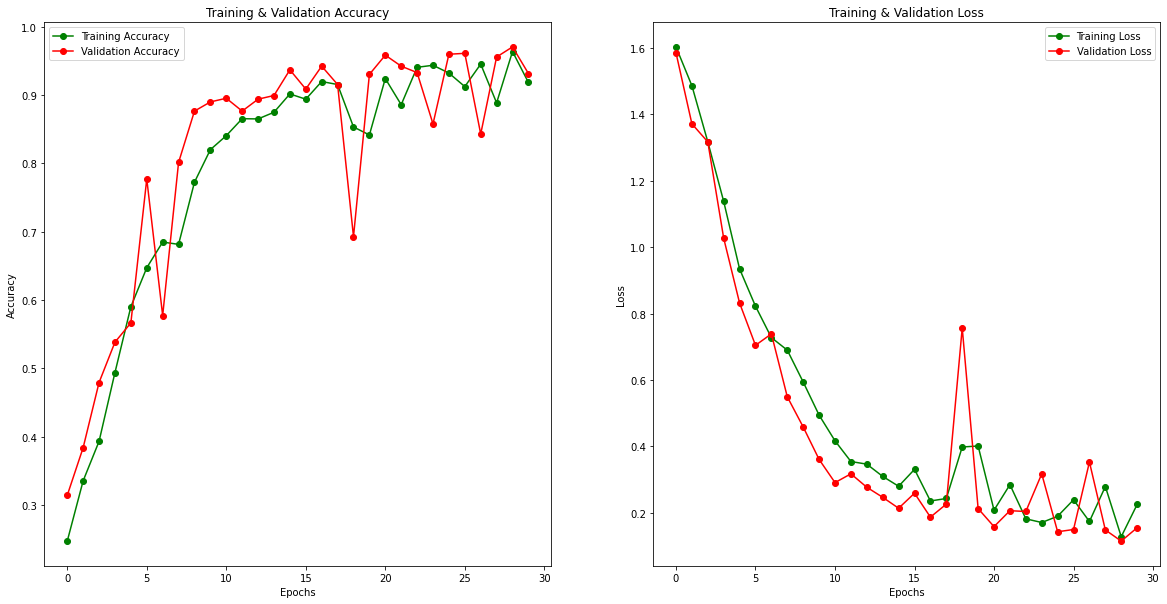

In [20]:
epochs = [i for i in range(EPOCHS)]

fig , ax = plt.subplots(1, 2)
train_acc = history.history['acc']
train_loss = history.history['loss']
val_acc = history.history['val_acc']
val_loss = history.history['val_loss']
fig.set_size_inches(20, 10)

ax[0].plot(epochs, train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs, val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Training & Validation Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

### Bidirectional (in development)

In [ ]:
bidirectional = Sequential()
bidirectional.add(Bidirectional(LSTM(50, activation="relu"), input_shape=(X.shape[1], X.shape[2])))
bidirectional.add(Dense(5, activation="softmax"))
bidirectional.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
bidirectional.summary()

In [ ]:
EPOCHS = 25
BATCH_SIZE = 64

bidirectional.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1)